In [ ]:
import pandas as pd
import mysql.connector
import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
from mlxtend.frequent_patterns import apriori, association_rules

# MySQL connection details
username = 'root'
password = 'teton123'
host = 'localhost'
database = 'retail_db'

# Create a MySQL connection
conn = mysql.connector.connect(
    host=host,
    user=username,
    password=password,
    database=database
)

# Step 1: Retrieve data from MySQL
query = "SELECT * FROM Invoices"
df = pd.read_sql(query, conn)

# Step 2: Data Cleaning and Preprocessing
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Ship_Date'] = pd.to_datetime(df['Ship_Date'])
df['Order_Year'] = df['Order_Date'].dt.year
df['Order YearMonth'] = df['Order_Date'].dt.to_period('M').astype(str)
df['Basket_ID'] = df.groupby(['Customer_ID', 'Order_Date']).ngroup()

# Calculate TotalAmount if not already present
if 'TotalAmount' not in df.columns:
    df['TotalAmount'] = df['Sales'] * df['Quantity']

# Analysis 1: Total Sales by State
total_sales_by_state = df.groupby('State')['TotalAmount'].sum().reset_index()
top_5_states = total_sales_by_state.sort_values(by='TotalAmount', ascending=False).head(5)


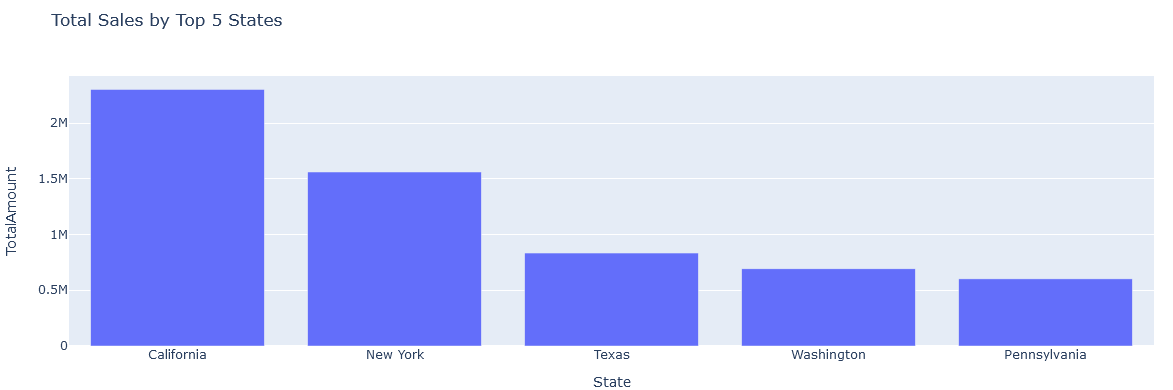

In [ ]:
# Analysis 2: Top 5 Products by Total Sales
top_5_products = df.groupby('Product_Name')['TotalAmount'].sum().reset_index().sort_values(by='TotalAmount', ascending=False).head(5)

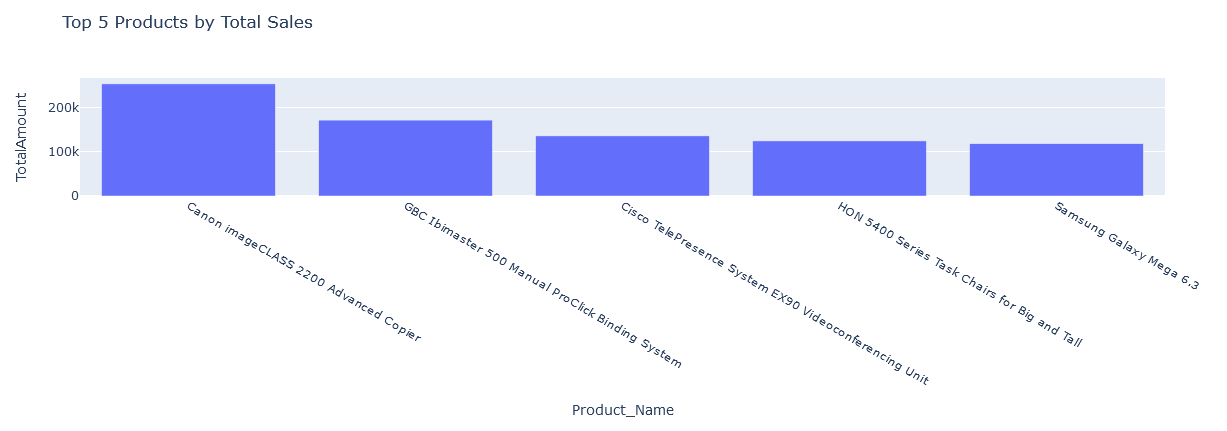

In [ ]:
# Analysis 3: Top 4 Years by Total Sales
top_4_years = df.groupby('Order_Year')['TotalAmount'].sum().reset_index().sort_values(by='TotalAmount', ascending=False).head(4)

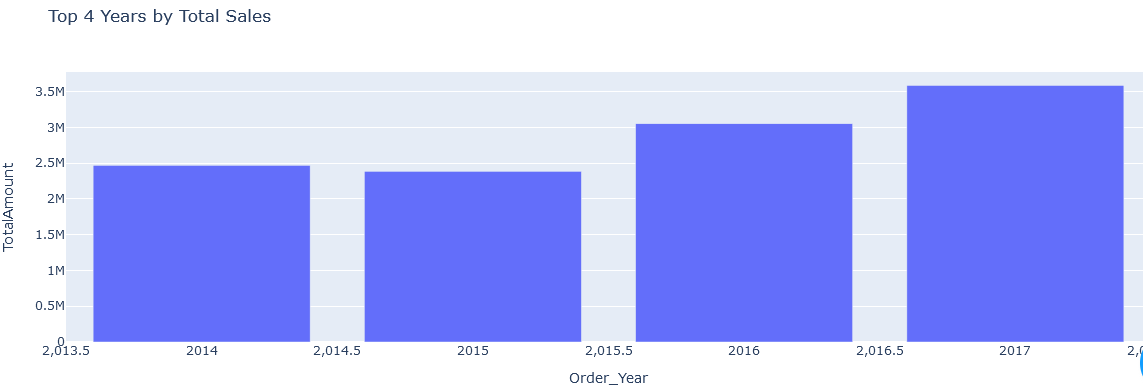

In [ ]:
# RFM Analysis
current_date = df['Order_Date'].max() + pd.DateOffset(1)
rfm_df = df.groupby('Customer_ID').agg({
    'Order_Date': lambda x: (current_date - x.max()).days,
    'Order_ID': 'count',
    'TotalAmount': 'sum'
}).reset_index()
rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm_df['RFM_Segment'] = (
    rfm_df['Recency'].apply(lambda x: '1' if x <= rfm_df['Recency'].quantile(0.25) else ('2' if x <= rfm_df['Recency'].quantile(0.50) else ('3' if x <= rfm_df['Recency'].quantile(0.75) else '4'))) +
    rfm_df['Frequency'].apply(lambda x: '4' if x > rfm_df['Frequency'].quantile(0.75) else ('3' if x > rfm_df['Frequency'].quantile(0.50) else ('2' if x > rfm_df['Frequency'].quantile(0.25) else '1'))) +
    rfm_df['Monetary'].apply(lambda x: '4' if x > rfm_df['Monetary'].quantile(0.75) else ('3' if x > rfm_df['Monetary'].quantile(0.50) else ('2' if x > rfm_df['Monetary'].quantile(0.25) else '1')))
)
rfm_df['RFM_Score'] = rfm_df['RFM_Segment'].apply(lambda x: int(x[0]) + int(x[1]) + int(x[2]))

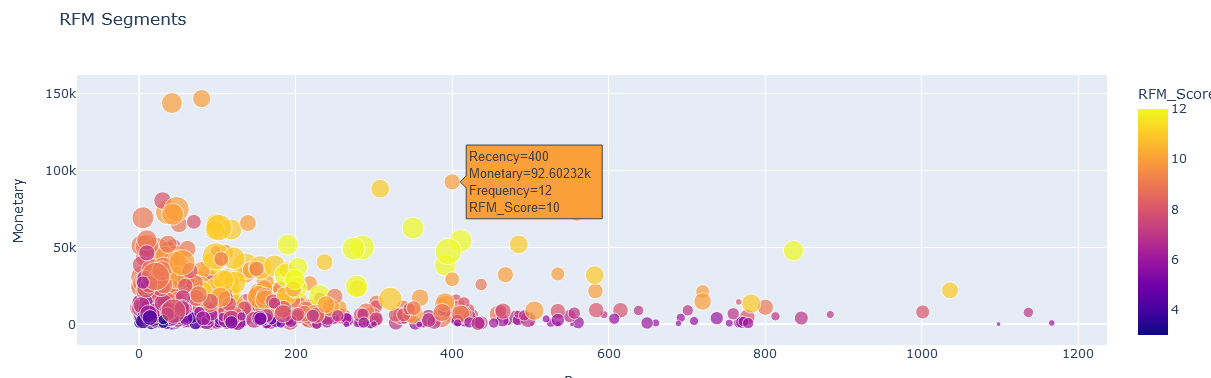

In [ ]:
# Additional Analyses from market.py
# 1. Profit Analysis by Category
profit_by_category = df.groupby('Category')['Profit'].sum().reset_index()


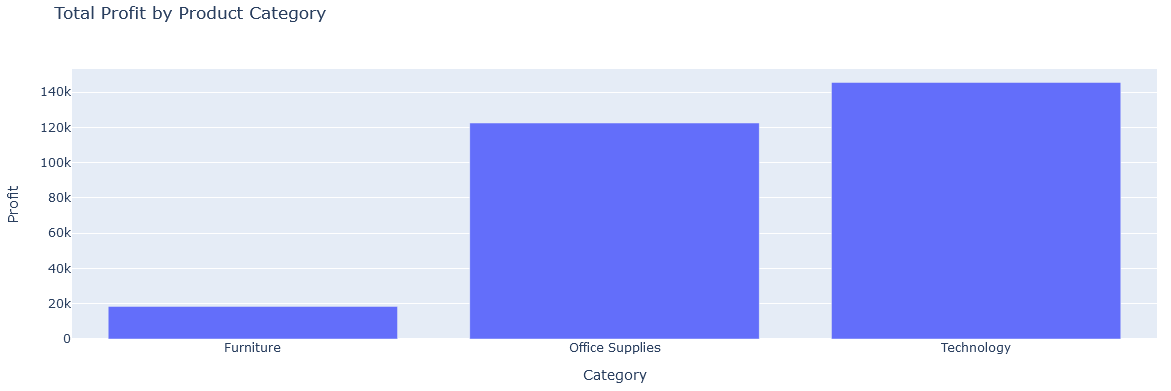


In [ ]:
# 2. Monthly Sales Trend Analysis
monthly_sales = df.groupby('Order YearMonth')['Sales'].sum().reset_index()


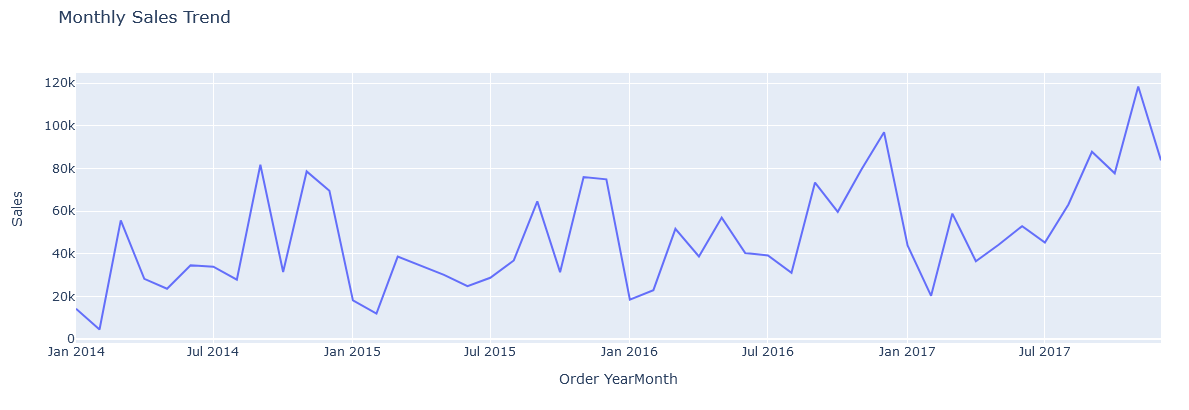

In [ ]:
# 3. Customer Segmentation Analysis
customer_segments = df.groupby('Customer_ID').agg({
    'Sales': 'sum',
    'Order_ID': 'nunique',
    'Quantity': 'sum'
}).reset_index()
customer_segments.columns = ['Customer ID', 'Total Sales', 'Total Orders', 'Total Quantity']


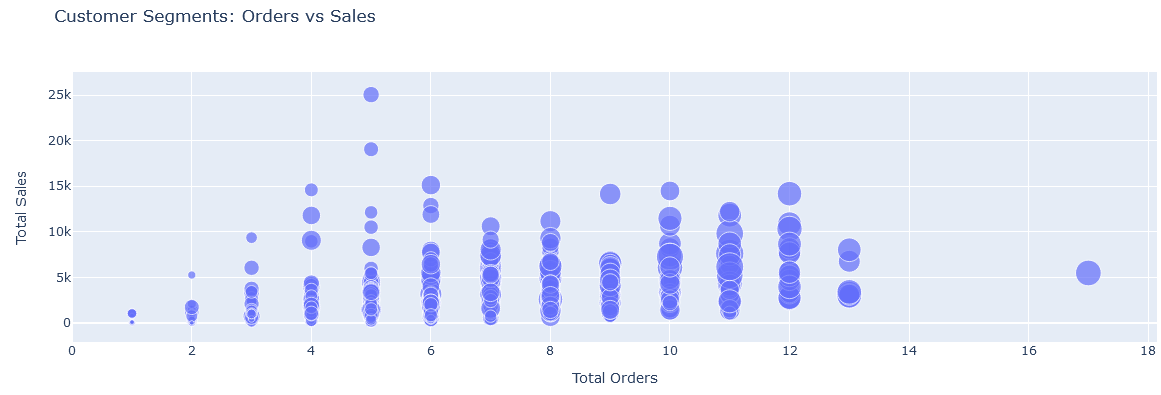


In [ ]:
# 4. Region-wise Sales Performance
sales_by_region = df.groupby('Region')['Sales'].sum().reset_index()

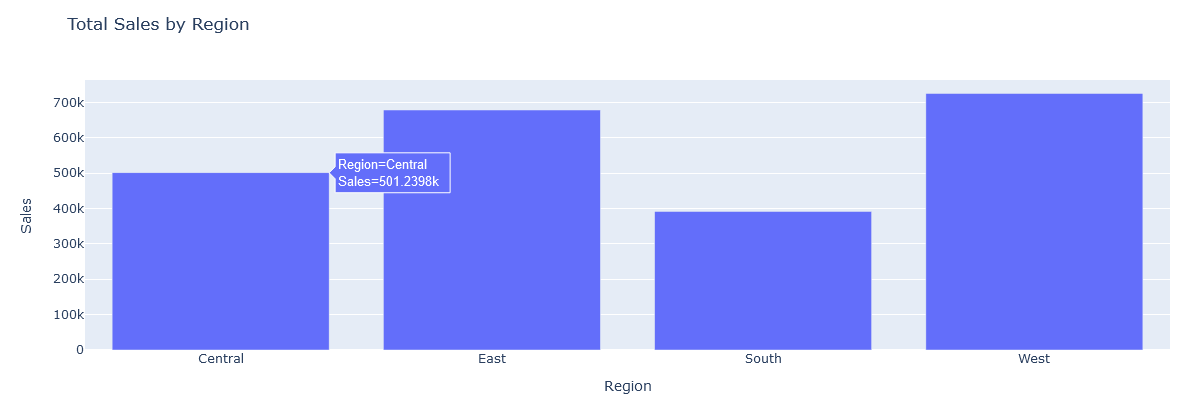

In [ ]:
# 5. Discount Impact on Sales and Profit
discount_impact = df.groupby('Discount').agg({
    'Sales': 'sum',
    'Profit': 'sum'
}).reset_index()


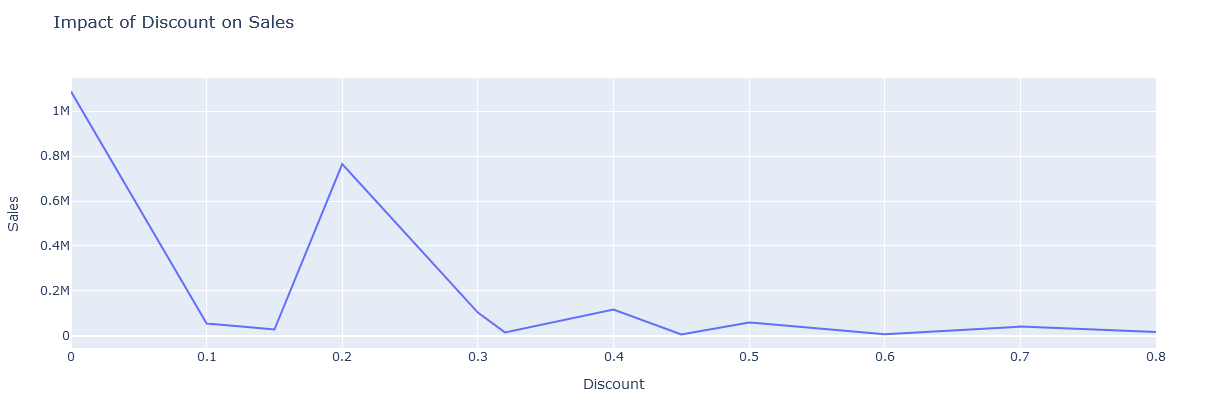



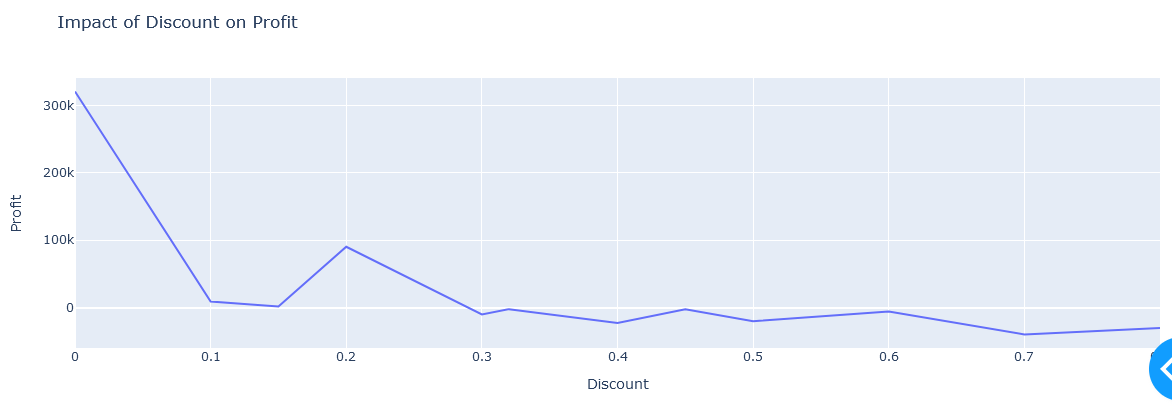

In [ ]:
# Create a Dash application
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Customer Segmentation and Sales Analysis Dashboard"),

    dcc.Tabs([
        dcc.Tab(label='Sales and Product Analysis', children=[
            html.H2("Total Sales by Top 5 States"),
            dcc.Graph(
                figure=px.bar(top_5_states, x='State', y='TotalAmount', title='Total Sales by Top 5 States')
            ),

            html.H2("Top 5 Products by Total Sales"),
            dcc.Graph(
                figure=px.bar(top_5_products, x='Product_Name', y='TotalAmount', title='Top 5 Products by Total Sales')
            ),

            html.H2("Top 4 Years by Total Sales"),
            dcc.Graph(
                figure=px.bar(top_4_years, x='Order_Year', y='TotalAmount', title='Top 4 Years by Total Sales')
            )
        ]),

        dcc.Tab(label='Customer Behavior and Discount Analysis', children=[
            html.H2("RFM Analysis"),
            dcc.Graph(
                figure=px.scatter(rfm_df, x='Recency', y='Monetary', size='Frequency', color='RFM_Score', title='RFM Segments')
            ),

            html.H2("Profit by Product Category"),
            dcc.Graph(
                figure=px.bar(profit_by_category, x='Category', y='Profit', title='Total Profit by Product Category')
            ),

            html.H2("Monthly Sales Trend"),
            dcc.Graph(
                figure=px.line(monthly_sales, x='Order YearMonth', y='Sales', title='Monthly Sales Trend')
            ),

            html.H2("Customer Segmentation Analysis"),
            dcc.Graph(
                figure=px.scatter(customer_segments, x='Total Orders', y='Total Sales', size='Total Quantity', title='Customer Segments: Orders vs Sales')
            ),

            html.H2("Total Sales by Region"),
            dcc.Graph(
                figure=px.bar(sales_by_region, x='Region', y='Sales', title='Total Sales by Region')
            ),

            html.H2("Impact of Discount on Sales"),
            dcc.Graph(
                figure=px.line(discount_impact, x='Discount', y='Sales', title='Impact of Discount on Sales')
            ),

            html.H2("Impact of Discount on Profit"),
            dcc.Graph(
                figure=px.line(discount_impact, x='Discount', y='Profit', title='Impact of Discount on Profit')
            )
        ])
    ])
])

if __name__ == '__main__':
    app.run_server(debug=True)


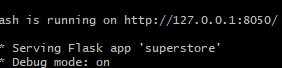

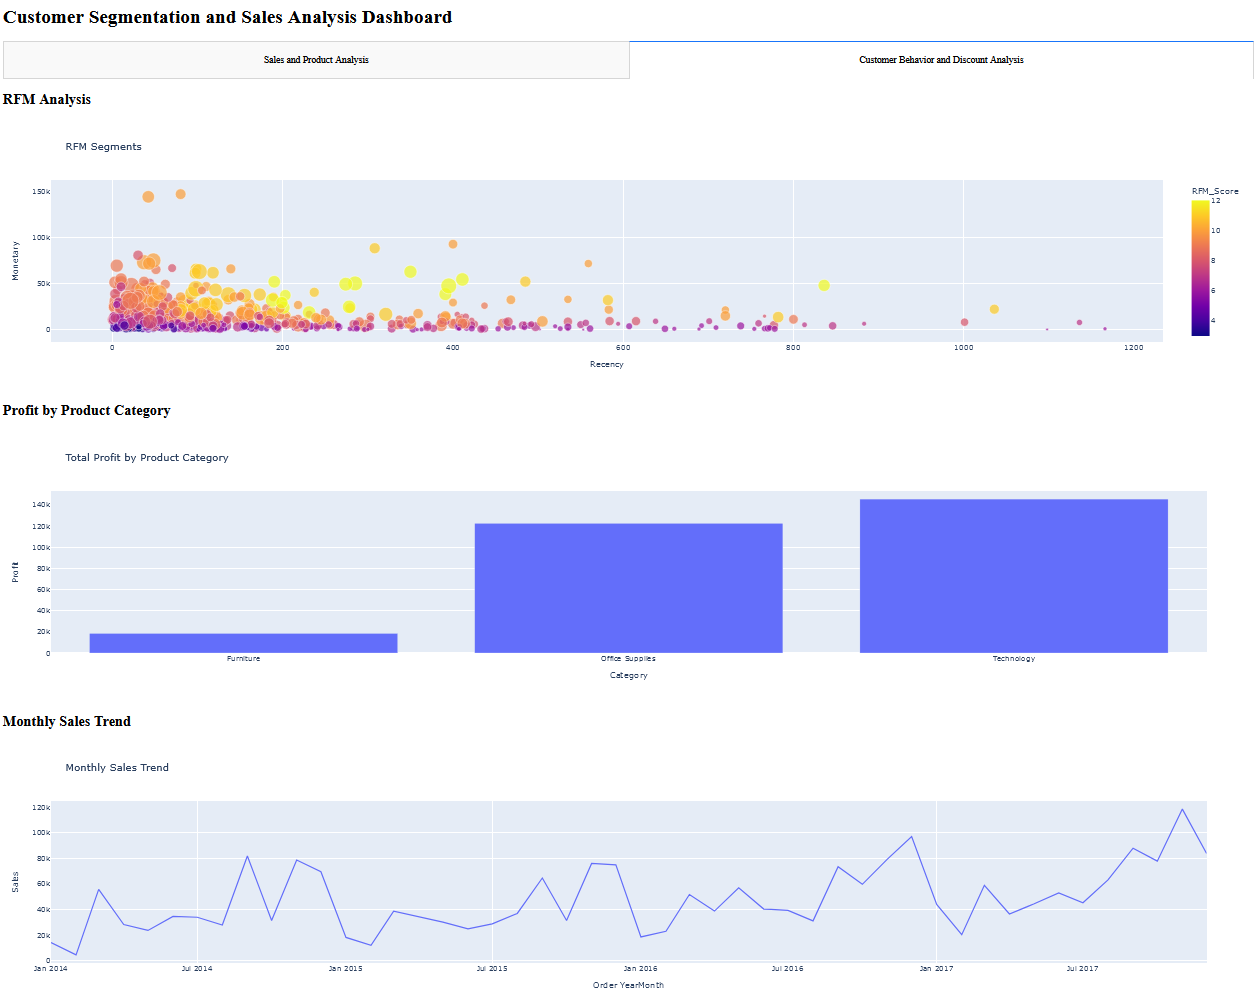

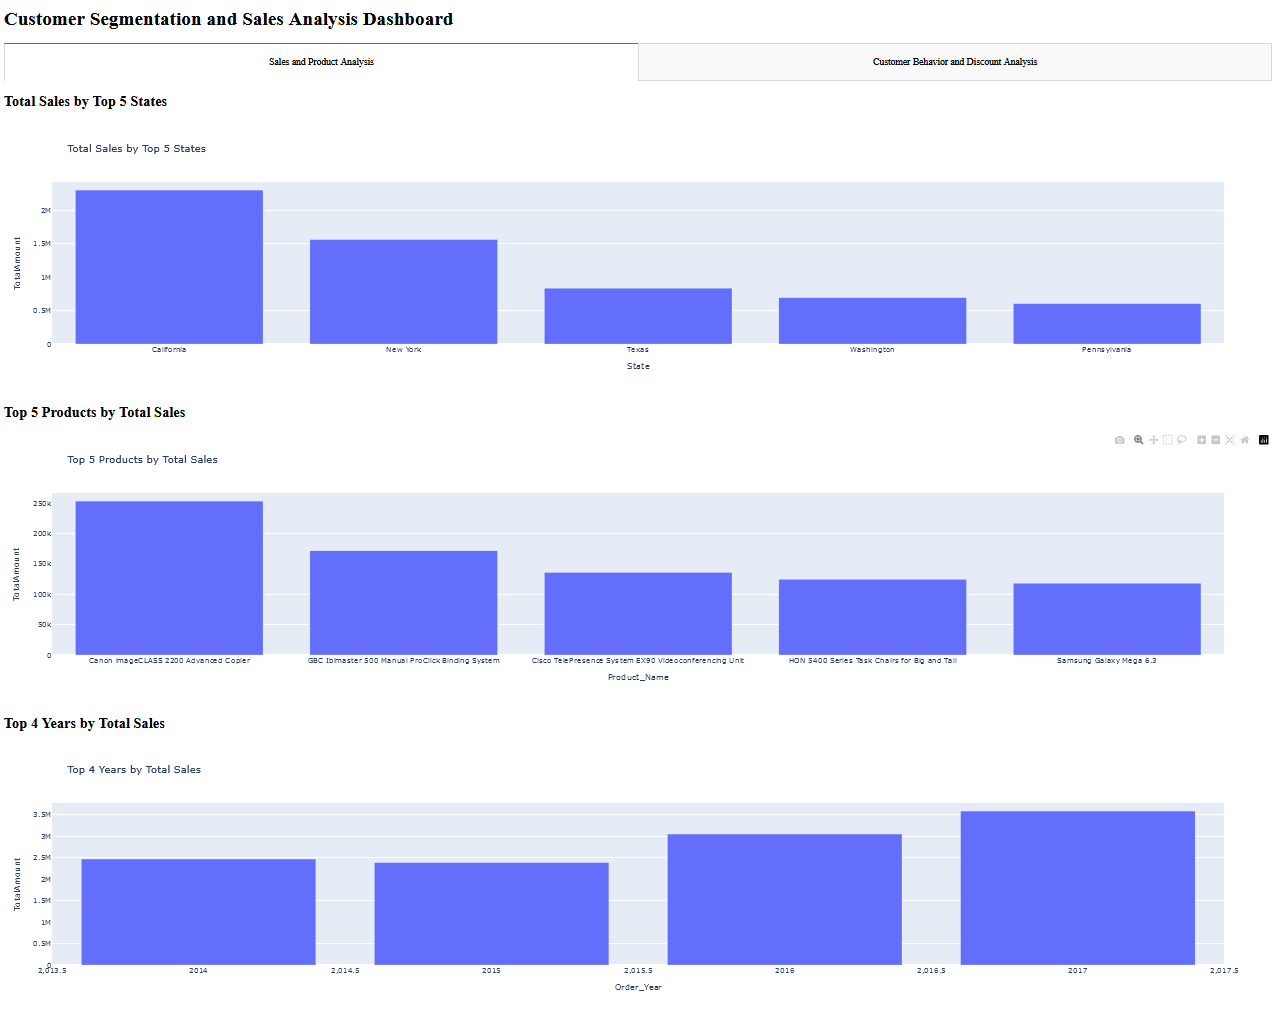
